In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [326]:
batch_size = 30 * 5
num_components = 3
action_dim = 1

pi = torch.zeros((batch_size, num_components))
pi[:, 0] = 0.15
pi[:, 1] = 0.5
pi[:, 2] = 0.35

# sigma = F.elu(torch.rand((batch_size, num_components, action_dim)) * 4.5) + 1
sigma = torch.zeros((batch_size, num_components, action_dim))
sigma[:, 0, :] = 0.3
sigma[:, 1, :] = 0.1
sigma[:, 2, :] = 0.15

# mu = torch.rand((batch_size, num_components, action_dim)) * 4.5
mu = torch.zeros((batch_size, num_components, action_dim))
mu[:, 0, :] = 3.5
mu[:, 1, :] = 0.1
mu[:, 2, :] = -1.2

mu[:, 0, :] += (np.arange(mu.shape[0])**2/100 * 0.01).reshape(-1, 1)
mu[:, 1, :] += (np.arange(mu.shape[0]) * 0.001).reshape(-1, 1)
mu[:, 2, :] -= (np.arange(mu.shape[0]) * 0.005).reshape(-1, 1)

pi.shape, sigma.shape, mu.shape

(torch.Size([150, 3]), torch.Size([150, 3, 1]), torch.Size([150, 3, 1]))

torch.Size([150])
torch.Size([150])
torch.Size([150])


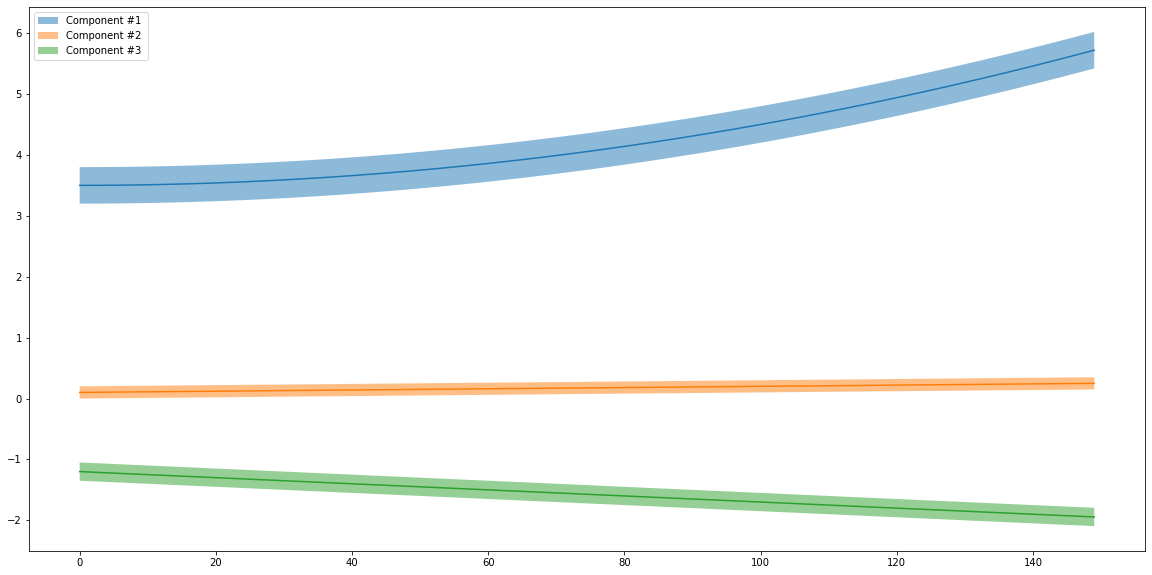

In [327]:
plt.figure(figsize=(20, 10))

for i_component in range(pi.shape[1]):
    probs = pi[:, i_component]
    mus = mu[:, i_component].squeeze()
    sigmas = sigma[:, i_component].squeeze()

    plt.plot(mus)

    print(mus.shape)

    plt.fill_between(np.arange(mus.shape[0]), mus - sigmas, mus + sigmas, alpha=0.5, label=f'Component #{i_component+1} ')

plt.legend()

In [445]:
import math
ONEOVERSQRT2PI = 1.0 / math.sqrt(2 * math.pi)
LOG2PI = math.log(2 * math.pi)

def gaussian_probability(sigma, mu, target, log=False):
    """Returns the probability of `target` given MoG parameters `sigma` and `mu`.

    Arguments:
        sigma (BxGxO): The standard deviation of the Gaussians. B is the batch
            size, G is the number of Gaussians, and O is the number of
            dimensions per Gaussian.
        mu (BxGxO): The means of the Gaussians. B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions per Gaussian.
        target (BxI): A batch of target. B is the batch size and I is the number of
            input dimensions.

    Returns:
        probabilities (BxG): The probability of each point in the probability
            of the distribution in the corresponding sigma/mu index.
    """
    target = target.unsqueeze(1).expand_as(sigma)
    if log:
        ret = (
            -torch.log(sigma)
            -0.5 * LOG2PI
            -0.5 * ((target - mu) / sigma) ** 2
        )
    else: 
        ret = (ONEOVERSQRT2PI / sigma) * torch.exp(
            -0.5 * ((target - mu) / sigma) ** 2
        )
    return ret.squeeze()

def mdn_logprob(pi, sigma, mu, target):
    """Calculates the error, given the MoG parameters and the target.
    """
    log_component_prob = gaussian_probability(sigma, mu, target, log=True)
    log_mix_prob = torch.log(
        F.softmax(pi, dim=-1) + 1e-15 # sharper distribution
    )

    log_sum_prob = torch.logsumexp(log_component_prob + log_mix_prob, dim=1)
    return log_sum_prob

def get_closest(array, values):
    '''Get indices of the closest values in `array` to `values`.
    Adapted from: https://stackoverflow.com/a/46184652/7948839
    
    Arguments:
        array (torch.Tensor): Array of values. Must be sorted.
        values (torch.Tensor): Values to find the closest indices for.
    
    Returns:
        indices (torch.Tensor): Indices of the closest values in `array`.
    '''
    # get insert positions
    idxs = torch.searchsorted(array, values, side="left")
    
    # find indexes where previous index is closer
    max_term = torch.maximum(idxs-1, torch.tensor([0]).repeat(len(idxs)))
    min_term = torch.minimum(idxs, torch.tensor([len(array)-1]).repeat(len(idxs)))
    prev_idx_is_less = ((idxs == len(array))|(torch.abs(values - array[max_term]) < torch.abs(values - array[min_term])))
    idxs[prev_idx_is_less] -= 1
    
    return idxs

In [446]:
n_samples = 1024
bound = 4.5

targets_grid = torch.linspace(-bound, bound, n_samples).repeat(pi.shape[0], 1).reshape(-1, 1)
pis_repeated = torch.repeat_interleave(pi, n_samples, dim=0)
sigmas_repeated = torch.repeat_interleave(sigma, n_samples, dim=0)
mus_repeated = torch.repeat_interleave(mu, n_samples, dim=0)

logprob_grid = mdn_logprob(pis_repeated, sigmas_repeated, mus_repeated, targets_grid).reshape(-1, n_samples)
prob_grid = torch.exp(logprob_grid)
inverted_prob_grid = 1 - prob_grid

In [447]:
true_targets = torch.zeros(pi.shape[0])
pred_targets = torch.zeros(pi.shape[0]) + 0.1

pred_targets[20] = 2
pred_targets[30] = 1
pred_targets[40] = -3

true_targets_x = get_closest(torch.linspace(-bound, bound, n_samples), true_targets)
pred_targets_x = get_closest(torch.linspace(-bound, bound, n_samples), pred_targets)


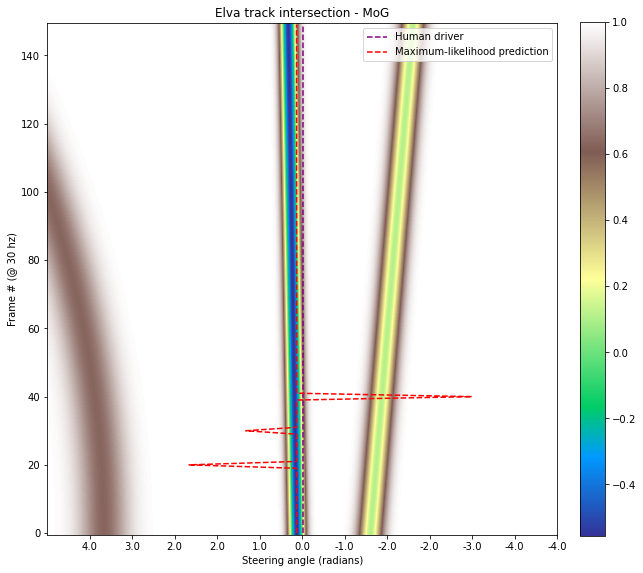

In [448]:
# bound_deg = math.degrees(bound)
plt.figure(figsize=(10,10))
plt.imshow(inverted_prob_grid, aspect=6.85, cmap='terrain')
plt.xticks(np.linspace(0, 1024, 13), np.linspace(-bound, bound, 13).round(0))
plt.plot(true_targets_x, torch.arange(0, pi.shape[0], 1), color='purple', linestyle='--', label='Human driver')
plt.plot(pred_targets_x, torch.arange(0, pi.shape[0], 1), color='red', linestyle='--', label='Maximum-likelihood prediction')
plt.title('Elva track intersection - MoG')
plt.xlabel('Steering angle (radians)')
plt.ylabel('Frame # (@ 30 hz)')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(fraction=0.046, pad=0.04)
plt.legend()

In [54]:
import sys
from pathlib import Path

sys.path.append('/home/nikita/e2e-driving/')

from dataloading.nvidia import NvidiaValidationDataset

In [116]:
valid_dataset = NvidiaValidationDataset(Path('/data/Bolt/end-to-end/rally-estonia-cropped'))

/data/Bolt/end-to-end/rally-estonia-cropped/2021-05-28-15-19-48_e2e_sulaoja_20_30: length=10708, filtered=0
/data/Bolt/end-to-end/rally-estonia-cropped/2021-06-07-14-20-07_e2e_rec_ss6: length=25836, filtered=1
/data/Bolt/end-to-end/rally-estonia-cropped/2021-06-07-14-06-31_e2e_rec_ss6: length=3003, filtered=0
/data/Bolt/end-to-end/rally-estonia-cropped/2021-06-07-14-09-18_e2e_rec_ss6: length=4551, filtered=1
/data/Bolt/end-to-end/rally-estonia-cropped/2021-06-07-14-36-16_e2e_rec_ss6: length=25368, filtered=1
/data/Bolt/end-to-end/rally-estonia-cropped/2021-09-24-14-03-45_e2e_rec_ss11_backwards: length=25172, filtered=0
/data/Bolt/end-to-end/rally-estonia-cropped/2021-10-26-10-49-06_e2e_rec_ss20_elva: length=33045, filtered=0
/data/Bolt/end-to-end/rally-estonia-cropped/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: length=33281, filtered=0
/data/Bolt/end-to-end/rally-estonia-cropped/2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back: length=26763, filtered=0
/data/Bolt/end-to-end/rally-estoni

In [117]:
elva_frames = valid_dataset.frames[valid_dataset.frames['image_path'].str.contains('elva')]
start_idx = 550 * 30
end_idx = 555 * 30
area_of_interest = elva_frames.iloc[start_idx:end_idx]

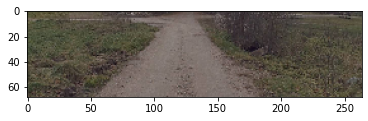

In [133]:
plt.imshow(plt.imread(area_of_interest.iloc[0]['image_path']))

In [144]:
area_of_interest.iloc[0]['index']

'2021-10-26 07:58:16.941536903'

In [154]:
valid_dataset.frames[valid_dataset.frames['index'] == area_of_interest.iloc[0]['index']]

,level_0,index,front_wide_filename,autonomous,left_filename,right_filename,steering_angle,cmd_steering_angle,vehicle_speed,turn_signal,position_x,position_y,position_z,roll,pitch,yaw,row_id,image_path
16500,16500,2021-10-26 07:58:16.941536903,front_wide/1635235096941536903.png,False,left/1635235096941536903.png,right/1635235096941536903.png,0.085732,NaN,10.520216,1,-8038.400527,-2137.031562,43.275741,-0.021561,0.059983,2.317594,16500,/data/Bolt/end-to-end/rally-estonia-cropped/20...


In [151]:
valid_dataset.frames.iloc[16500].image_path

'/data/Bolt/end-to-end/rally-estonia-cropped/2021-06-07-14-20-07_e2e_rec_ss6/front_wide/1623065001566663980.png'

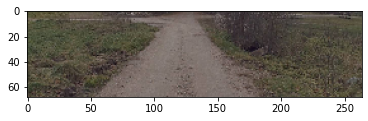

In [138]:
# plt.imshow(plt.imread(valid_dataset.frames[area_of_interest.index[0]]))
plt.imshow(plt.imread(elva_frames.iloc[area_of_interest.index[0]]['image_path']))

In [155]:
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False,
                                               num_workers=1, pin_memory=True,
                                               persistent_workers=True, collate_fn=valid_dataset.collate_fn)

In [158]:
len(valid_loader)

3475

In [157]:
from copy import deepcopy

valid_loader_copy = deepcopy(valid_loader)
valid_loader_copy.dataset.frames = area_of_interest

len(valid_loader_copy)

3

In [159]:
valid_loader_copy.dataset.frames

,level_0,index,front_wide_filename,autonomous,left_filename,right_filename,steering_angle,cmd_steering_angle,vehicle_speed,turn_signal,position_x,position_y,position_z,roll,pitch,yaw,row_id,image_path
16500,16500,2021-10-26 07:58:16.941536903,front_wide/1635235096941536903.png,False,left/1635235096941536903.png,right/1635235096941536903.png,0.085732,NaN,10.520216,1,-8038.400527,-2137.031562,43.275741,-0.021561,0.059983,2.317594,16500,/data/Bolt/end-to-end/rally-estonia-cropped/20...
16501,16501,2021-10-26 07:58:16.974889994,front_wide/1635235096974889994.png,False,left/1635235096974889994.png,right/1635235096974889994.png,0.081699,NaN,10.530661,1,-8038.641832,-2136.774185,43.261850,-0.021851,0.060206,2.317826,16501,/data/Bolt/end-to-end/rally-estonia-cropped/20...
16502,16502,2021-10-26 07:58:17.008188009,front_wide/1635235097008188009.png,False,left/1635235097008188009.png,right/1635235097008188009.png,0.070071,NaN,10.617383,1,-8038.871952,-2136.528462,43.248106,-0.022362,0.060027,2.318187,16502,/data/Bolt/end-to-end/rally-estonia-cropped/20...
16503,16503,2021-10-26 07:58:17.041517019,front_wide/1635235097041517019.png,False,left/1635235097041517019.png,right/1635235097041517019.png,0.056734,NaN,10.513717,1,-8039.125911,-2136.257874,43.232556,-0.022366,0.059361,2.318274,16503,/data/Bolt/end-to-end/rally-estonia-cropped/20...
16504,16504,2021-10-26 07:58:17.074873924,front_wide/1635235097074873924.png,False,left/1635235097074873924.png,right/1635235097074873924.png,0.052198,NaN,10.440671,1,-8039.366127,-2136.001272,43.217916,-0.023686,0.059166,2.318688,16504,/data/Bolt/end-to-end/rally-estonia-cropped/20...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16645,16645,2021-10-26 07:58:21.774909973,front_wide/1635235101774909973.png,False,left/1635235101774909973.png,right/1635235101774909973.png,-0.091000,NaN,9.113312,1,-8069.293195,-2103.376604,42.689401,0.001375,0.009372,2.270688,16645,/data/Bolt/end-to-end/rally-estonia-cropped/20...
16646,16646,2021-10-26 07:58:21.808215857,front_wide/1635235101808215857.png,False,left/1635235101808215857.png,right/1635235101808215857.png,-0.089198,NaN,9.080000,1,-8069.487095,-2103.147655,42.689777,0.000908,0.008620,2.270037,16646,/data/Bolt/end-to-end/rally-estonia-cropped/20...
16647,16647,2021-10-26 07:58:21.841571808,front_wide/1635235101841571808.png,False,left/1635235101841571808.png,right/1635235101841571808.png,-0.087000,NaN,9.090263,1,-8069.688930,-2102.908828,42.690450,0.000933,0.007689,2.269605,16647,/data/Bolt/end-to-end/rally-estonia-cropped/20...
16648,16648,2021-10-26 07:58:21.874891996,front_wide/1635235101874891996.png,False,left/1635235101874891996.png,right/1635235101874891996.png,-0.084819,NaN,9.116696,1,-8069.886203,-2102.673583,42.690742,0.001390,0.006418,2.269339,16648,/data/Bolt/end-to-end/rally-estonia-cropped/20...


In [168]:
import time

history = []

for i, (input, target, _) in enumerate(valid_loader_copy):
    print(i)
    # print(input.keys())
    # print(input['row_id'])
    # print(target)
    # plt.imshow(input['image'][0].permute(1, 2, 0).numpy())
    # plt.show()

    history.append(torch.zeros((64, 3, 1)))

0
1
2


In [170]:
history.append(torch.zeros(32, 3, 1))

In [171]:
torch.vstack(history).shape

torch.Size([224, 3, 1])